In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Simula líneas suaves entre puntos para visualización
from scipy.interpolate import interp1d

## mTAN model

In [57]:
class TimeEmbedding(nn.Module):
    def __init__(self, time_dim):
        super().__init__()
        self.linear = nn.Linear(1, time_dim)

    def forward(self, t):
        # t: [B, L, 1]
        sin_emb = torch.sin(t)
        cos_emb = torch.cos(t)
        linear_emb = self.linear(t)
        return torch.cat([linear_emb, sin_emb, cos_emb], dim=-1)  # [B, L, time_dim + 2]

class MultiTimeAttention(nn.Module):
    def __init__(self, input_dim, time_dim, embed_dim, n_heads=1):
        super().__init__()
        self.time_embedding = TimeEmbedding(time_dim)
        self.q_proj = nn.Linear(time_dim + 2, embed_dim)
        self.k_proj = nn.Linear(time_dim + 2, embed_dim)
        self.v_proj = nn.Linear(input_dim, embed_dim)
        self.n_heads = n_heads
        self.embed_dim = embed_dim

    def forward(self, x, t, r):
        phi_t = self.time_embedding(t)  # [B, L, D_t]
        phi_r = self.time_embedding(r)  # [B, R, D_t]

        Q = self.q_proj(phi_r)
        K = self.k_proj(phi_t)
        V = self.v_proj(x)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.embed_dim ** 0.5
        attn_weights = F.softmax(scores, dim=-1)
        h_r = torch.matmul(attn_weights, V)
        return h_r, attn_weights, scores


In [58]:
class Decoder(nn.Module):
    def __init__(self, embed_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(embed_dim, output_dim)

    def forward(self, h_r):
        return self.linear(h_r)

### Example

In [59]:
# Semilla para reproducibilidad
np.random.seed(42)

# Simular tiempos irregulares
t1 = np.sort(np.random.uniform(0, 3, size=25))
t2 = np.sort(np.random.uniform(0, 3, size=20))

# Simular valores observados (patrón + ruido)
x1 = np.sin(2 * np.pi * t1 / 3) + 0.1 * np.random.randn(len(t1))       # temperatura
x2 = np.cos(2 * np.pi * t2 / 3 + 1.5) + 0.1 * np.random.randn(len(t2)) # humedad

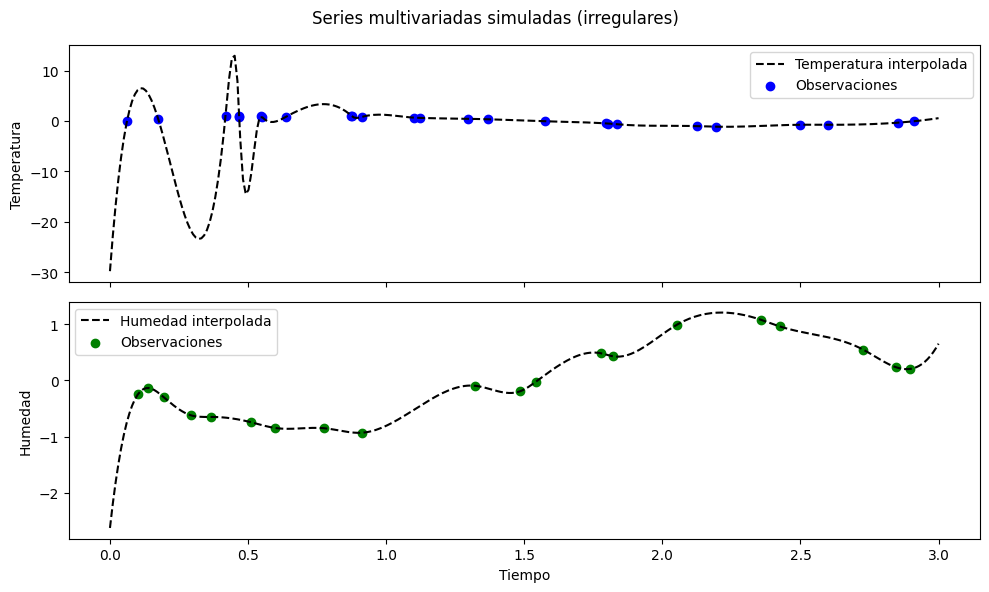

In [60]:
# Interpolación para visualización
t_dense = np.linspace(0, 3, 300)
f1 = interp1d(t1, x1, kind='cubic', fill_value='extrapolate')
f2 = interp1d(t2, x2, kind='cubic', fill_value='extrapolate')

# Graficar
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(t_dense, f1(t_dense), 'k--', label='Temperatura interpolada')
axes[0].scatter(t1, x1, color='blue', label='Observaciones')
axes[0].set_ylabel('Temperatura')
axes[0].legend()

axes[1].plot(t_dense, f2(t_dense), 'k--', label='Humedad interpolada')
axes[1].scatter(t2, x2, color='green', label='Observaciones')
axes[1].set_ylabel('Humedad')
axes[1].set_xlabel('Tiempo')
axes[1].legend()

plt.suptitle("Series multivariadas simuladas (irregulares)")
plt.tight_layout()
plt.show()

In [61]:
# Unificar tiempos
t_all = torch.tensor(sorted(set(t1.tolist() + t2.tolist()))).float()
L = len(t_all)

# Inicializar x con NaNs
x_all = torch.full((L, 2), float('nan'))

# Asignar observaciones
for i, t_val in enumerate(t_all):
    if t_val.item() in t1:
        x_all[i, 0] = torch.tensor(x1[np.where(t1 == t_val.item())[0][0]])
    if t_val.item() in t2:
        x_all[i, 1] = torch.tensor(x2[np.where(t2 == t_val.item())[0][0]])

# Batch de tamaño 1
x = x_all.unsqueeze(0)        # [1, L, 2]
t = t_all.view(1, -1, 1)      # [1, L, 1]

# Máscara de observaciones
mask = ~torch.isnan(x)
x = torch.nan_to_num(x, nan=0.0)

In [62]:
# Hiperparámetros
input_dim = 2
time_dim = 16
embed_dim = 32

encoder = MultiTimeAttention(input_dim, time_dim, embed_dim)
decoder = Decoder(embed_dim, input_dim)

# Tiempo de referencia regular
r_ref = torch.linspace(0, 3, 100).view(1, -1, 1)

# Crear objetivos (targets) en r_ref
r_vals = r_ref[0,:,0]
targets = torch.full((1, len(r_vals), input_dim), float('nan'))

for i, r_i in enumerate(r_vals):
    idx = (t[0,:,0] - r_i).abs().argmin()
    targets[0, i] = x[0, idx]

mask_r = ~torch.isnan(targets)
targets = torch.nan_to_num(targets, nan=0.0)

# Optimizador
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
loss_fn = nn.MSELoss()

# Entrenamiento
for epoch in range(200):
    encoder.train()
    decoder.train()

    h_r, _, _ = encoder(x, t, r_ref)
    x_hat = decoder(h_r)

    loss = loss_fn(x_hat[mask_r], targets[mask_r])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 0.0216
Epoch 20: Loss = 0.0003
Epoch 40: Loss = 0.0000
Epoch 60: Loss = 0.0000
Epoch 80: Loss = 0.0000
Epoch 100: Loss = 0.0000
Epoch 120: Loss = 0.0000
Epoch 140: Loss = 0.0000
Epoch 160: Loss = 0.0000
Epoch 180: Loss = 0.0000


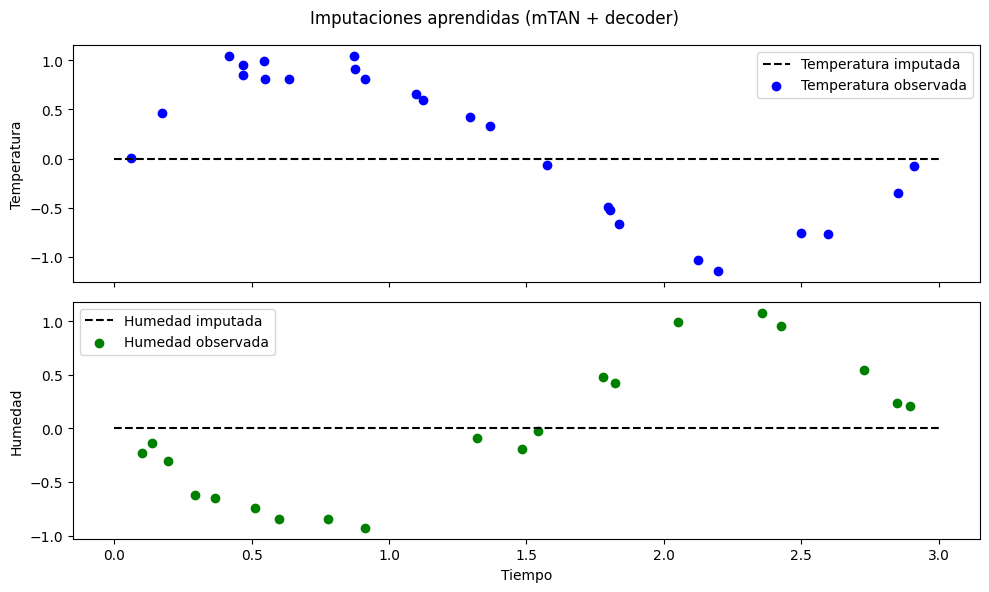

In [63]:
# Evaluación y visualización
encoder.eval()
decoder.eval()

with torch.no_grad():
    h_r, _, _ = encoder(x, t, r_ref)
    x_hat = decoder(h_r)[0].numpy()  # [R, 2]
    r_plot = r_ref[0,:,0].numpy()

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Temperatura
axes[0].plot(r_plot, x_hat[:,0], 'k--', label='Temperatura imputada')
axes[0].scatter(t1, x1, color='blue', label='Temperatura observada')
axes[0].set_ylabel("Temperatura")
axes[0].legend()

# Humedad
axes[1].plot(r_plot, x_hat[:,1], 'k--', label='Humedad imputada')
axes[1].scatter(t2, x2, color='green', label='Humedad observada')
axes[1].set_ylabel("Humedad")
axes[1].set_xlabel("Tiempo")
axes[1].legend()

plt.suptitle("Imputaciones aprendidas (mTAN + decoder)")
plt.tight_layout()
plt.show()

## Forecasting one step ahead

In [111]:
torch.manual_seed(0)

# Simular 2 series de tiempo irregulares
t1 = torch.tensor([0.3, 0.7, 1.1, 1.4, 2.0, 2.2, 2.6], dtype=torch.float32).view(1, -1, 1)
x1 = torch.tensor([0.1, 0.6, 1.0, 0.8, 0.3, 0.5, 0.4], dtype=torch.float32).view(1, -1, 1)

t2 = torch.tensor([0.2, 0.8, 1.5, 2.1, 2.3, 2.7], dtype=torch.float32).view(1, -1, 1)
x2 = torch.tensor([0.5, 0.4, -0.2, 0.1, 0.3, 0.7], dtype=torch.float32).view(1, -1, 1)

# Concatenar ambas como input multivariable
t = torch.cat([t1, t2], dim=1)  # [1, L, 1]
x = torch.cat([x1, x2], dim=1)  # [1, L, 1] -> luego haremos input_dim=2

# Ordenar por tiempo
idx_sort = t[0,:,0].argsort()
t = t[:, idx_sort, :]
x = x[:, idx_sort, :]

# Agregar canal de humedad con ceros por ahora
x_pad = torch.cat([x, torch.zeros_like(x)], dim=-1)  # [1, L, 2]
input_dim = x_pad.shape[-1]

In [133]:
torch.manual_seed(0)

# ---------- Serie 1: Temperatura ----------
n1 = 45  # Número de puntos (puedes ajustar entre 20 y 40)
t1_vals = np.sort(np.random.uniform(0.0, 3.0, n1))  # Tiempos irregulares
x1_vals = np.sin(2 * np.pi * t1_vals / 3) + 0.1 * np.random.randn(n1)  # Temperatura

t1 = torch.tensor(t1_vals, dtype=torch.float32).view(1, -1, 1)
x1 = torch.tensor(x1_vals, dtype=torch.float32).view(1, -1, 1)

# ---------- Serie 2: Humedad ----------
n2 = 30  # Número de puntos (puedes ajustar entre 20 y 40)
t2_vals = np.sort(np.random.uniform(0.0, 3.0, n2))  # Tiempos irregulares
x2_vals = 0.5 * np.cos(2 * np.pi * t2_vals / 3) + 0.1 * np.random.randn(n2)  # Humedad

t2 = torch.tensor(t2_vals, dtype=torch.float32).view(1, -1, 1)
x2 = torch.tensor(x2_vals, dtype=torch.float32).view(1, -1, 1)

# ---------- Unir como entrada multivariable ----------
t = torch.cat([t1, t2], dim=1)  # [1, L, 1]
x = torch.cat([x1, x2], dim=1)  # [1, L, 1]

# Ordenar por tiempo
idx_sort = t[0, :, 0].argsort()
t = t[:, idx_sort, :]
x = x[:, idx_sort, :]

# Agregar canal de humedad con ceros por ahora (para predecir ambos canales)
x_pad = torch.cat([x, torch.zeros_like(x)], dim=-1)  # [1, L, 2]
input_dim = x_pad.shape[-1]

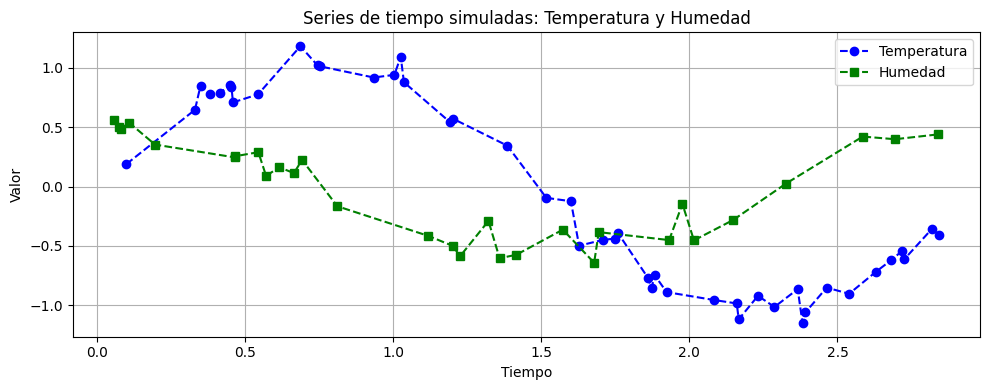

In [134]:
plt.figure(figsize=(10, 4))

# Serie 1: Temperatura (azul)
plt.plot(t1[0].numpy(), x1[0].numpy(), 'o--', color='blue', label='Temperatura')
# Serie 2: Humedad (verde)
plt.plot(t2[0].numpy(), x2[0].numpy(), 's--', color='green', label='Humedad')

plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.title("Series de tiempo simuladas: Temperatura y Humedad")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [135]:
time_dim = 16
embed_dim = 32

encoder = MultiTimeAttention(input_dim=2, time_dim=time_dim, embed_dim=embed_dim)
decoder = Decoder(embed_dim=embed_dim, output_dim=2)

In [136]:
# Tiempos de referencia regulares
r_ref = torch.linspace(0.0, 3.0, 60).view(1, -1, 1)

# Tiempo futuro (no observado)
t_futuro = torch.tensor([[[3.2]]], dtype=torch.float32)
r_ext = torch.cat([r_ref, t_futuro], dim=1)  # [1, R+1, 1]

In [137]:
r_vals = r_ref[0,:,0]
targets = torch.full((1, len(r_vals), input_dim), float('nan'))

for i, r_i in enumerate(r_vals):
    idx = (t[0,:,0] - r_i).abs().argmin()
    targets[0, i] = x_pad[0, idx]

mask_r = ~torch.isnan(targets)
targets = torch.nan_to_num(targets, nan=0.0)

# Crear valor objetivo para el futuro
x_futuro_real = torch.tensor([[[np.sin(2 * np.pi * 3.2 / 3), 0.0]]], dtype=torch.float32)  # solo temperatura

In [138]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(300):
    encoder.train()
    decoder.train()

    h_r, _, _ = encoder(x_pad, t, r_ext)       # [1, R+1, D]
    x_hat = decoder(h_r)                       # [1, R+1, 2]

    # Pérdida reconstrucción (en r_ref)
    loss_rec = loss_fn(x_hat[0, :-1][mask_r[0]], targets[0][mask_r[0]])

    # Pérdida de predicción (última posición)
    loss_pred = loss_fn(x_hat[0, -1], x_futuro_real[0, 0])

    loss = loss_rec + loss_pred

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss rec = {loss_rec.item():.4f}, pred = {loss_pred.item():.4f}")

Epoch 0: Loss rec = 0.2029, pred = 0.1657
Epoch 50: Loss rec = 0.2166, pred = 0.0337
Epoch 100: Loss rec = 0.2066, pred = 0.0277
Epoch 150: Loss rec = 0.1335, pred = 0.0089
Epoch 200: Loss rec = 0.0871, pred = 0.0008
Epoch 250: Loss rec = 0.0814, pred = 0.0007


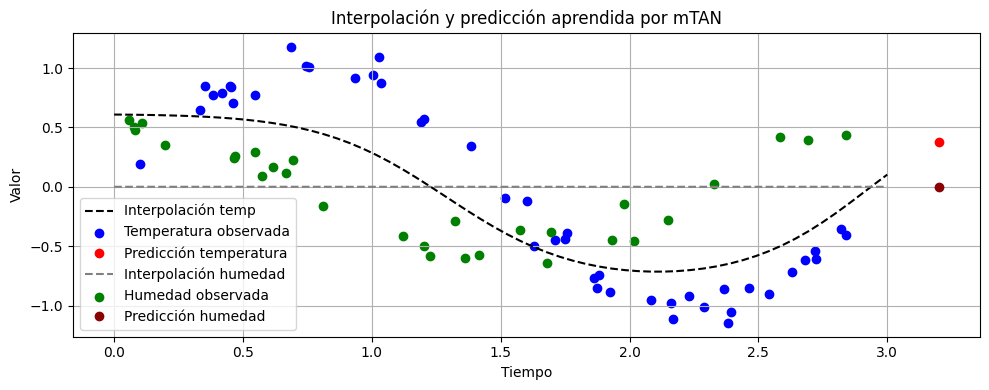

In [139]:
# Convertir a NumPy (detached)
t1_np = t1[0].detach().numpy()
x1_np = x1[0].detach().numpy()
t2_np = t2[0].detach().numpy()
x2_np = x2[0].detach().numpy()

r_plot_np = r_ref[0].detach().numpy()              # [R]
x_hat_np = x_hat[0, :-1].detach().numpy()          # [R, 2]
x_pred_np = x_hat[0, -1].detach().numpy()          # [2]
t_pred_np = t_futuro[0, 0, 0].item()               # Escalar

plt.figure(figsize=(10, 4))

# ---- Temperatura ----
plt.plot(r_plot_np, x_hat_np[:, 0], 'k--', label='Interpolación temp')
plt.scatter(t1_np, x1_np, color='blue', label='Temperatura observada')
plt.plot(t_pred_np, x_pred_np[0], 'ro', label='Predicción temperatura')

# ---- Humedad ----
plt.plot(r_plot_np, x_hat_np[:, 1], 'gray', linestyle='--', label='Interpolación humedad')
plt.scatter(t2_np, x2_np, color='green', label='Humedad observada')
plt.plot(t_pred_np, x_pred_np[1], 'o', color='darkred', label='Predicción humedad')

plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.title("Interpolación y predicción aprendida por mTAN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [140]:
# Evaluación sin gradientes
encoder.eval()
decoder.eval()

with torch.no_grad():
    h_r, attn_weights, scores = encoder(x_pad, t, r_ext)
    x_hat = decoder(h_r)[0].numpy()
    attn_weights_np = attn_weights[0].numpy()  # [R+1, L]
    r_plot = r_ext[0,:,0].numpy()
    t_obs = t[0,:,0].numpy()

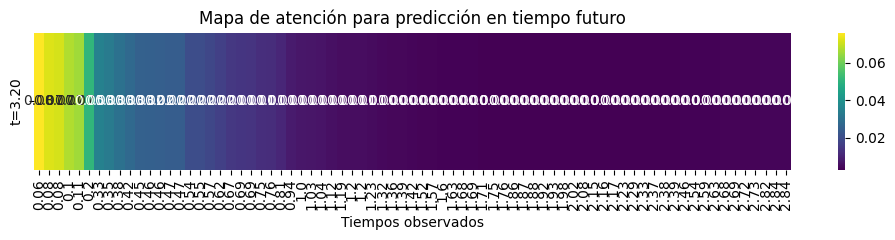

In [141]:
plt.figure(figsize=(10, 2.5))
sns.heatmap(
    attn_weights_np[-1:].clip(1e-5, 1),  # último tiempo (futuro)
    xticklabels=np.round(t_obs, 2),
    yticklabels=[f"t={r_plot[-1]:.2f}"],
    cmap='viridis',
    cbar=True,
    annot=True,
    fmt=".2f"
)
plt.xlabel("Tiempos observados")
plt.title("Mapa de atención para predicción en tiempo futuro")
plt.tight_layout()
plt.show()

In [123]:
# Predicción y valor real
y_pred = x_hat[-1, 0]  # temperatura
y_true = x_futuro_real[0, 0, 0].item()

mae = abs(y_pred - y_true)
rmse = np.sqrt((y_pred - y_true) ** 2)
mape = abs((y_true - y_pred) / y_true) * 100 if y_true != 0 else np.nan

print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")

MAE  = 0.0291
RMSE = 0.0291
MAPE = 7.16%


--------------------------------

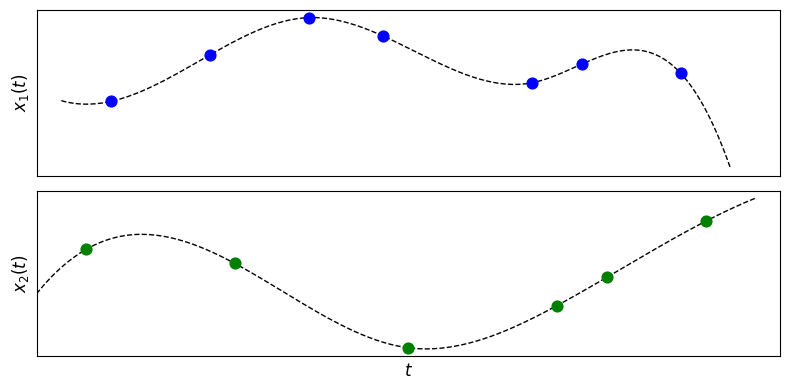

In [49]:
# Datos de entrada simulados
t1 = torch.tensor([0.3, 0.7, 1.1, 1.4, 2.0, 2.2, 2.6]).view(-1).numpy()
x1 = torch.tensor([0.1, 0.6, 1.0, 0.8, 0.3, 0.5, 0.4]).view(-1).numpy()

t2 = torch.tensor([0.2, 0.8, 1.5, 2.1, 2.3, 2.7]).view(-1).numpy()
x2 = torch.tensor([0.5, 0.4, -0.2, 0.1, 0.3, 0.7]).view(-1).numpy()


t1_interp = np.linspace(min(t1)-0.2, max(t1)+0.2, 200)
f1 = interp1d(t1, x1, kind='cubic', fill_value='extrapolate')
x1_interp = f1(t1_interp)

t2_interp = np.linspace(min(t2)-0.2, max(t2)+0.2, 200)
f2 = interp1d(t2, x2, kind='cubic', fill_value='extrapolate')
x2_interp = f2(t2_interp)

# Graficar en subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Serie 1
axes[0].plot(t1_interp, x1_interp, 'k--', linewidth=1)
axes[0].scatter(t1, x1, color='blue', s=60, zorder=3)
axes[0].set_ylabel(r'$x_1(t)$', fontsize=12)
axes[0].set_xlim(0, 3)
axes[0].grid(False)
axes[0].set_yticks([])
axes[0].set_xticks([])

# Serie 2
axes[1].plot(t2_interp, x2_interp, 'k--', linewidth=1)
axes[1].scatter(t2, x2, color='green', s=60, zorder=3)
axes[1].set_ylabel(r'$x_2(t)$', fontsize=12)
axes[1].set_xlabel(r'$t$', fontsize=12)
axes[1].set_xlim(0, 3)
axes[1].grid(False)
axes[1].set_yticks([])

plt.tight_layout()
plt.show()